In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, auc, roc_auc_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import preprocessor as p

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# TF-IDF process

In [2]:
df = pd.read_csv('long_covid1003_unique.csv', encoding= 'unicode_escape')
print(f'Total shape : {df.shape}\nLabel distribution : \n\t0:{df.shape[0]-df.label.values.sum()}\n\t1:{df.label.values.sum()}')
df, val_df = train_test_split(df, test_size = 0.2, stratify = df.label, random_state = 42 )
val_df, test_df = train_test_split(val_df, test_size = 0.5, stratify = val_df.label, random_state = 42 )
df = pd.concat([df, val_df])
df = df.reset_index(drop=True)
print('Split shape : ',df.shape, test_df.shape)

Total shape : (2927, 3)
Label distribution : 
	0:566
	1:2361
Split shape :  (2634, 3) (293, 3)


## Preprocessing

In [3]:
wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer  = PorterStemmer()

p.set_options(p.OPT.URL, p.OPT.EMOJI)

def preprocess(row, lemmatizer, stemmer):
    text = row['tweet']
    text = text.strip('\xa0')
    text = p.clean(text)
    # tokenization = nltk.word_tokenize(text)     
    # tokenization = [w for w in tokenization if not w in stop_words]
    # text = ' '.join([porter_stemmer.stem(w) for w in tokenization])
    # text = ' '.join([lemmatizer.lemmatize(w) for w in tokenization])
    # text = re.sub(r'\([0-9]+\)', '', text).strip()    
    return text

df['tweet'] = df.apply(lambda x: preprocess(x, wordnet_lemmatizer, porter_stemmer), 1)
val_df['tweet'] = val_df.apply(lambda x: preprocess(x, wordnet_lemmatizer, porter_stemmer), 1)
test_df['tweet'] = test_df.apply(lambda x: preprocess(x, wordnet_lemmatizer, porter_stemmer), 1)

In [4]:
train_features = df["tweet"].values
train_label = df["label"].values
TEST_features = test_df["tweet"].values
TEST_label = test_df["label"].values

In [5]:
train_label

array([1, 1, 1, ..., 1, 1, 1])

In [2]:
from sklearn.model_selection import KFold
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
#from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer


In [7]:
kf = KFold(n_splits = 5, shuffle = True)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), min_df=1,)
#tfidf_vectorizer = TfidfVectorizer(stop_words='english',  ngram_range=(1, 3), token_pattern=r"(?u)\b\w+\b")
#tfidf_vectorizer = TfidfVectorizer(max_features=10000,token_pattern=r"(?u)\b\w+\b")


### 1 val_acc:0.93738 ###


### 2 val_acc:0.90702 ###


### 3 val_acc:0.89753 ###


### 4 val_acc:0.90512 ###


### 5 val_acc:0.94106 ###

=====================Kfold Performance======================

              precision    recall  f1-score   support

           0       0.85      0.69      0.76       509
           1       0.93      0.97      0.95      2125

    accuracy                           0.92      2634
   macro avg       0.89      0.83      0.86      2634
weighted avg       0.91      0.92      0.91      2634
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

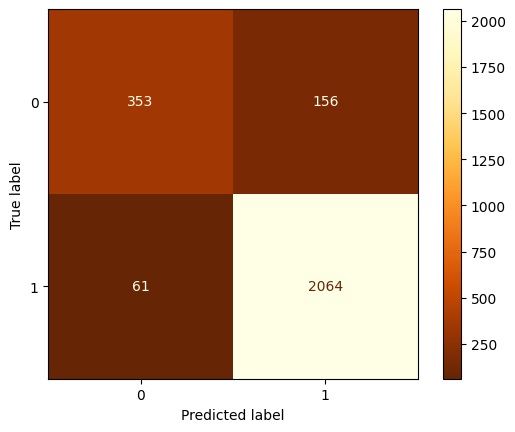

In [10]:
expected_kfold = []
predicted_kfold = []
valid_acc = []
valid_f1 = []
valid_auc = []
models = []
clf_models = []
tfidf_vectorizer.fit(df["tweet"])

for idx, (train_index, vali_index) in enumerate(kf.split(df)):
    x_train = [train_features[i] for i in train_index]
    y_train = train_label[train_index]
    x_vali = [train_features[i] for i in vali_index]
    y_vali = train_label[vali_index]

    # TF-IDF
    x_train_tfidf = tfidf_vectorizer.transform(x_train)
    x_vali_tfidf = tfidf_vectorizer.transform(x_vali)
    classifier = LinearSVC()
    #classifier.fit(x_train_tfidf, y_train)
    
    #for predict_prob
    clf = CalibratedClassifierCV(classifier) 
    clf.fit(x_train_tfidf, y_train)
    
    
    # make predicitions
    expected = y_vali
    #predicted = classifier.predict(x_vali_tfidf)
    predicted = clf.predict(x_vali_tfidf)
    predicted_prob = clf.predict_proba(x_vali_tfidf)[:,1]
    #print(predicted_prob)
    
    expected_kfold.extend(expected)
    predicted_kfold.extend(predicted)
    models.append(classifier)
    clf_models.append(clf)
    val_score = accuracy_score(expected, predicted)
    valid_acc.append(val_score)
    val_f1 = f1_score(expected, predicted)
    valid_f1.append(val_f1)
    val_auc = roc_auc_score(expected, predicted_prob)
    valid_auc.append(val_auc)
    print(f"\n### {idx+1} val_acc:{val_score:.5f} ###\n")
    #print(f'val_acc:{val_score:.5f}')
    #print(f'{metrics.classification_report(expected, predicted)}{"-"*60:>600}')

print(f'{"===Kfold Performance===":=^60}\n')
print(f'{metrics.classification_report(expected_kfold, predicted_kfold)}{"-"*60:>600}')
print(f'5-fold ACC: {sum(valid_acc)/5*100:.2f}% std:{np.std(valid_acc)}')
print(f'5-fold F1: {sum(valid_f1)/5*100:.2f}%  std:{np.std(valid_f1)}')
print(f'5-fold AUC: {sum(valid_auc)/5*100:.2f}% std:{np.std(valid_auc)}')
print(f"\nConfusion Matrix\n")
cm = confusion_matrix(expected_kfold, predicted_kfold)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')

## Rf: Prediction

No.0 Accuracy: 87.37% Precision: 90.61% Recall: 94.07% F1: 92.31% AUC: 92.03%
No.1 Accuracy: 89.08% Precision: 91.13% Recall: 95.76% F1: 93.39% AUC: 91.58%
No.2 Accuracy: 89.08% Precision: 91.46% Recall: 95.34% F1: 93.36% AUC: 92.02%
No.3 Accuracy: 87.71% Precision: 90.98% Recall: 94.07% F1: 92.50% AUC: 92.07%
No.4 Accuracy: 88.40% Precision: 91.39% Recall: 94.49% F1: 92.92% AUC: 92.67%
*********************************************
Mean acc: 88.33%
Mean pre: 91.12%
Mean rec: 94.75%
Mean F1-score: 92.89%
Mean AUC: 92.07%


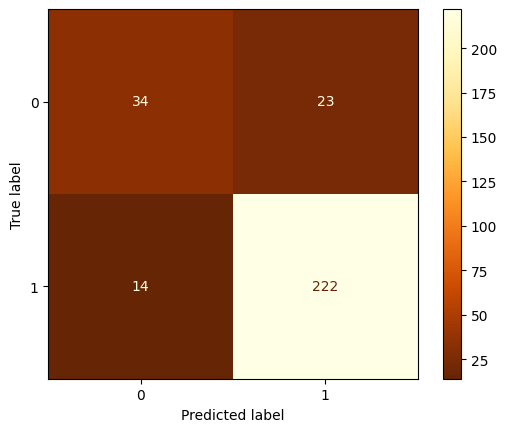

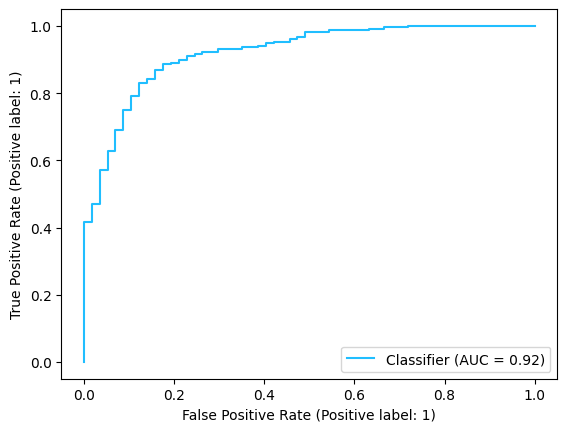

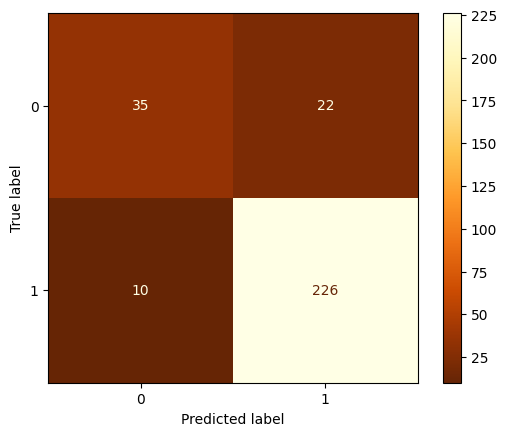

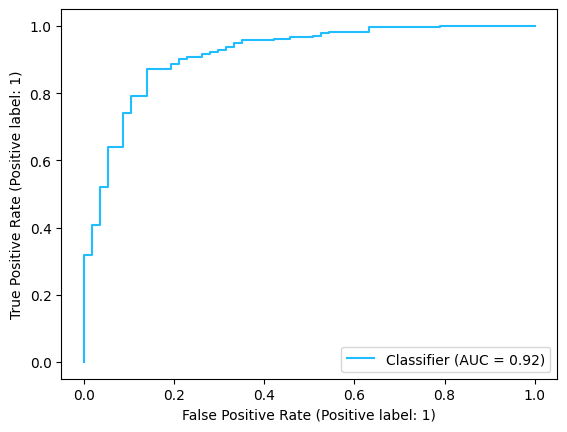

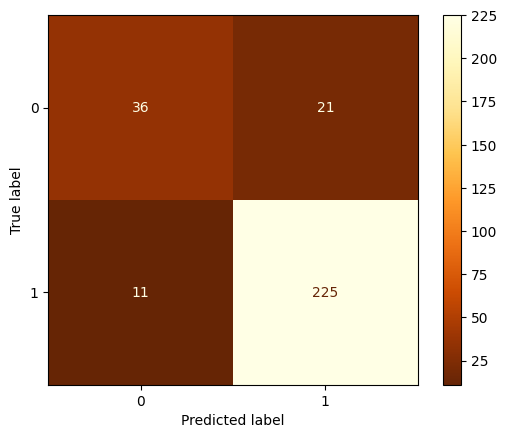

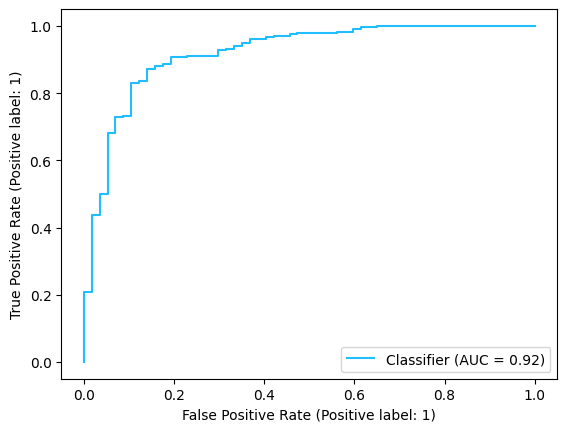

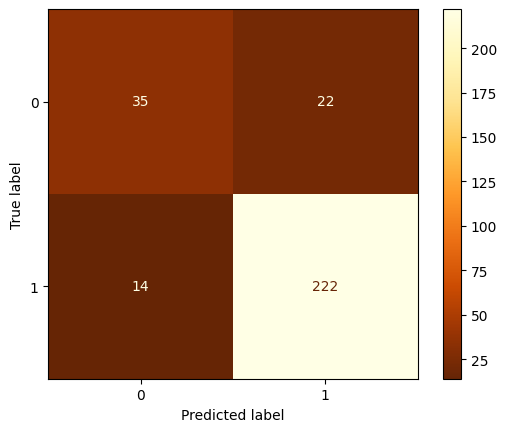

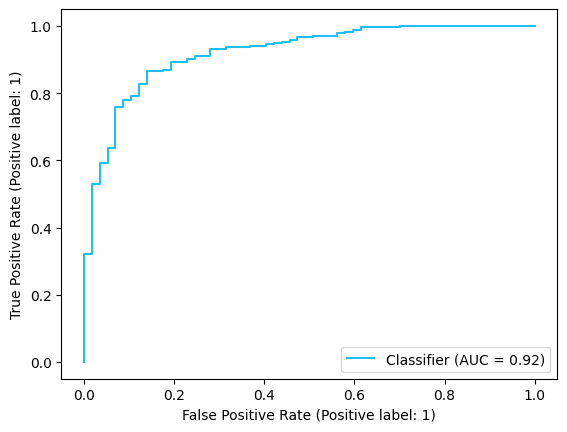

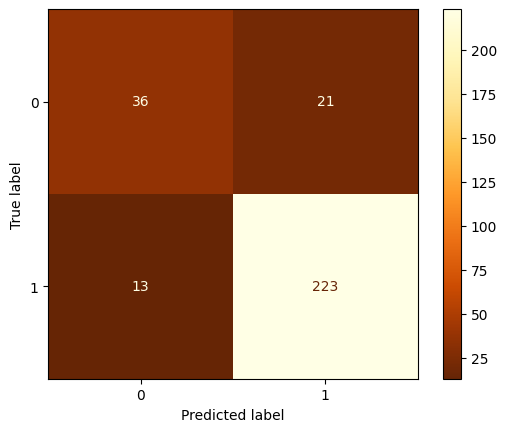

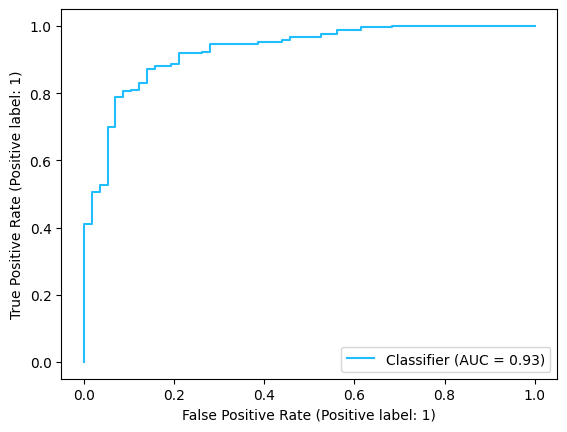

In [12]:
#x_train = train_features
x_TEST = TEST_features

# TF-IDF
# x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_TEST_tfidf = tfidf_vectorizer.transform(x_TEST)

test_acc = []
test_pre = []
test_rec = []
test_f1 = []
test_auc = []
for i in range(5):
    y_pred = clf_models[i].predict(x_TEST_tfidf)
    y_pred_prob = clf_models[i].predict_proba(x_TEST_tfidf)[:,1]
    # Acc
    accuracy = accuracy_score(TEST_label, y_pred)
    test_acc.append(accuracy)
    # Precision
    precision = precision_score(TEST_label, y_pred)
    test_pre.append(precision)
    # Recall
    recall = recall_score(TEST_label, y_pred)
    test_rec.append(recall)
    # F1-score
    f1 = f1_score(TEST_label, y_pred) 
    test_f1.append(f1)
    # AUC
    auc = roc_auc_score(TEST_label, y_pred_prob) 
    test_auc.append(auc)
    print(f"No.{i}","Accuracy: %.2f%%" % (accuracy * 100), "Precision: %.2f%%" % (precision * 100), "Recall: %.2f%%" % (recall * 100), "F1: %.2f%%" % (f1 * 100), "AUC: %.2f%%" % (auc * 100))
    cm = confusion_matrix(TEST_label, y_pred)
    cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')
    RocCurveDisplay.from_predictions(TEST_label, y_pred_prob, color='#20BEFF')

print('*'*45)
print(f'Mean acc: {sum(test_acc)/5*100:.2f}%')
print(f'Mean pre: {sum(test_pre)/5*100:.2f}%')
print(f'Mean rec: {sum(test_rec)/5*100:.2f}%')
print(f'Mean F1-score: {sum(test_f1)/5*100:.2f}%')
print(f'Mean AUC: {sum(test_auc)/5*100:.2f}%')


In [ ]:
# Save model for future usage
from joblib import dump, load
dump(models[2], "LinearSVM_0926.joblib")

In [8]:
from joblib import dump, load
testmodel = load("LinearSVM_0926.joblib")
testmodel.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [ ]:
# output result to csv file
with open("./kaggle_submission.csv", "w", encoding="utf-8") as f:
    f.write(f'Id,Label\n')
    for idx, item in enumerate(TEST_predict_result):
        f.write(f'{idx},{item}\n')

In [78]:
classifier = RandomForestClassifier(n_estimators=310)
#classifier = XGBClassifier(n_estimators=100, learning_rate= 0.3)
#classifier = LogisticRegression()

kf = KFold(n_splits = 10, shuffle = True)
tfidf_vectorizer = TfidfVectorizer(max_features=10000,token_pattern=r"(?u)\b\w+\b")


### 1 val_acc:0.77273 ###


### 2 val_acc:0.84848 ###


### 3 val_acc:0.90909 ###


### 4 val_acc:0.86364 ###


### 5 val_acc:0.86364 ###


### 6 val_acc:0.84848 ###


### 7 val_acc:0.89231 ###


### 8 val_acc:0.87692 ###


### 9 val_acc:0.87692 ###


### 10 val_acc:0.86154 ###

=====================Kfold Performance======================

              precision    recall  f1-score   support

           0       0.80      0.94      0.86       303
           1       0.94      0.79      0.86       353

    accuracy                           0.86       656
   macro avg       0.87      0.87      0.86       656
weighted avg       0.87      0.86      0.86       656
                                                                                                                                                                                                                                                                                                                                           

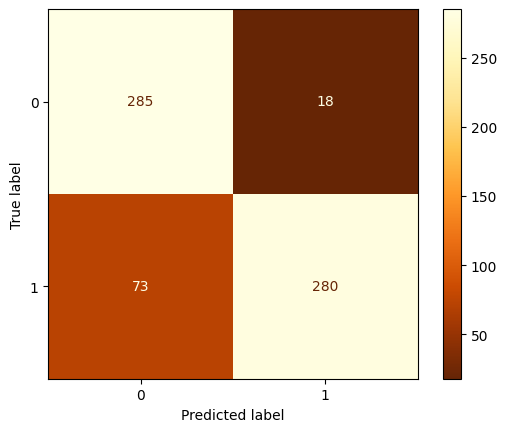

In [79]:
expected_kfold = []
predicted_kfold = []
valid_acc = []
models = []


for idx, (train_index, vali_index) in enumerate(kf.split(df)):
    x_train = [train_features[i] for i in train_index]
    y_train = train_label[train_index]
    x_vali = [train_features[i] for i in vali_index]
    y_vali = train_label[vali_index]

    # TF-IDF
    x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
    x_vali_tfidf = tfidf_vectorizer.transform(x_vali)
    classifier.fit(x_train_tfidf, y_train)
    # make predicitions
    expected = y_vali
    predicted = classifier.predict(x_vali_tfidf)
    expected_kfold.extend(expected)
    predicted_kfold.extend(predicted)
    models.append(classifier)
    val_score = accuracy_score(expected, predicted)
    valid_acc.append(val_score)
    print(f"\n### {idx+1} val_acc:{val_score:.5f} ###\n")
    #print(f'val_acc:{val_score:.5f}')
    #print(f'{metrics.classification_report(expected, predicted)}{"-"*60:>600}')

print(f'{"===Kfold Performance===":=^60}\n')
print(f'{metrics.classification_report(expected_kfold, predicted_kfold)}{"-"*60:>600}')
print(f'10-fold ACC: {sum(valid_acc)/10*100:.2f}%')
print(f"\nConfusion Matrix\n")
cm = confusion_matrix(expected_kfold, predicted_kfold)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')

In [40]:
x_TEST = TEST_features

# TF-IDF
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_TEST_tfidf = tfidf_vectorizer.transform(x_TEST)

# make predicitions
TEST_predict_result = classifier.predict(x_TEST_tfidf)

test_acc = []
for i in range(10):
    y_pred = models[i].predict(x_TEST_tfidf)
    # 计算分类准确率
    accuracy = accuracy_score(TEST_label, y_pred)
    test_acc.append(accuracy)
    print(f"No.{i}","Accuracy: %.2f%%" % (accuracy * 100))
print('*'*45)
print(f'Mean acc: {sum(test_acc)/10:.5f}')

No.0 Accuracy: 86.30%
No.1 Accuracy: 86.30%
No.2 Accuracy: 86.30%
No.3 Accuracy: 86.30%
No.4 Accuracy: 86.30%
No.5 Accuracy: 86.30%
No.6 Accuracy: 86.30%
No.7 Accuracy: 86.30%
No.8 Accuracy: 86.30%
No.9 Accuracy: 86.30%
*********************************************
Mean acc: 0.86301


In [80]:
print(x_train[1])
print("="*40)
print(x_train_tfidf[1])

@ AndrewYang Serious question . Why f * ck need take vaccine 95 % efficacy telling side effect , everybody 70 catch COVID 99.997 % chance recovery ?
  (0, 7155)	0.09219516942710933
  (0, 1822)	0.20404309509313645
  (0, 531)	0.3165375613223171
  (0, 529)	0.2235728355770429
  (0, 1727)	0.2738635585998902
  (0, 441)	0.2235728355770429
  (0, 3380)	0.25589968988233286
  (0, 3103)	0.16240757902264322
  (0, 8010)	0.18243680940107349
  (0, 8728)	0.2816273295689402
  (0, 3109)	0.2322280425293969
  (0, 516)	0.2612061531017298
  (0, 9445)	0.1255674246340287
  (0, 1966)	0.3369587377895275
  (0, 3521)	0.2389533268465133
  (0, 9801)	0.21618917824793982
  (0, 7882)	0.1564754578415992
  (0, 6111)	0.1530939990583025
  (0, 7056)	0.1957680017807294
  (0, 8653)	0.15441946550792782
  (0, 2517)	0.06960880011029053
['我不喜歡橙子' '我愛吃蘋果' '橙子有些很酸' '蘋果很好吃' '香蕉是我的最愛']


In [49]:
texts = ["我愛吃蘋果", "蘋果很好吃", "我不喜歡橙子", "橙子有些很酸", "香蕉是我的最愛"]
labels = [0, 0, 1, 1, 2]  # 假設 0 是 "蘋果", 1 是 "橙子", 2 是 "香蕉"

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(texts)
print(X_train_tfidf)
print(vectorizer.get_feature_names_out() )

  (0, 1)	1.0
  (1, 3)	1.0
  (2, 0)	1.0
  (3, 2)	1.0
  (4, 4)	1.0
['我不喜歡橙子' '我愛吃蘋果' '橙子有些很酸' '蘋果很好吃' '香蕉是我的最愛']


In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names_out())
print(X.shape)
print(X[2])

['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']
(4, 9)
  (0, 4)	0.511848512707169
  (0, 7)	0.511848512707169
  (0, 0)	0.511848512707169
  (0, 6)	0.267103787642168
  (0, 3)	0.267103787642168
  (0, 8)	0.267103787642168


# GPT_embedding

In [13]:
from sklearn.model_selection import KFold
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
#from xgboost import XGBClassifier

from sklearn import metrics

In [6]:
df = pd.read_csv('long_covid1117_unique_train.csv')
val_df = pd.read_csv('long_covid1117_unique_val.csv')
test_df = pd.read_csv('long_covid1117_unique_test.csv')
df = pd.concat([df, val_df])
df = df.reset_index(drop=True)
print('Split shape : ',df.shape, test_df.shape)

Split shape :  (2634, 4) (293, 4)


In [21]:
df['ada_embedding'] = df.ada_embedding.apply(eval).apply(np.array)
test_df['ada_embedding'] = test_df.ada_embedding.apply(eval).apply(np.array)

In [22]:
train_features = df["ada_embedding"].values
train_label = df["label"].values
TEST_features = test_df["ada_embedding"].values
TEST_label = test_df["label"].values

In [23]:
kf = KFold(n_splits = 5, shuffle = True)


### 1 val_acc:0.93169 ###


### 2 val_acc:0.93169 ###


### 3 val_acc:0.92410 ###


### 4 val_acc:0.92220 ###


### 5 val_acc:0.92205 ###

=====================Kfold Performance======================

              precision    recall  f1-score   support

           0       0.86      0.74      0.80       509
           1       0.94      0.97      0.96      2125

    accuracy                           0.93      2634
   macro avg       0.90      0.86      0.88      2634
weighted avg       0.92      0.93      0.92      2634
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

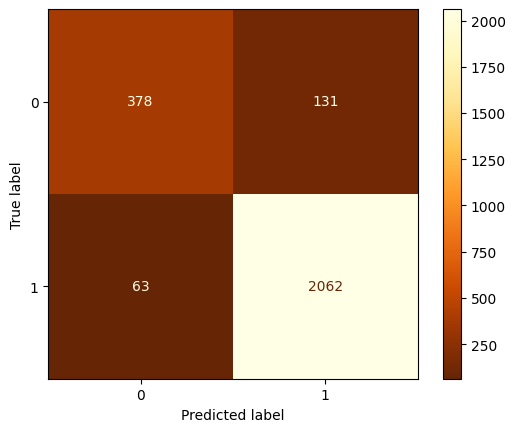

In [28]:
expected_kfold = []
predicted_kfold = []
valid_acc = []
valid_f1 = []
valid_auc = []
models = []
clf_models = []

for idx, (train_index, vali_index) in enumerate(kf.split(df)):
    x_train = [train_features[i] for i in train_index]
    y_train = train_label[train_index]
    x_vali = [train_features[i] for i in vali_index]
    y_vali = train_label[vali_index]

    # TF-IDF
    classifier = LinearSVC()
    #classifier.fit(x_train_tfidf, y_train)
    
    #for predict_prob
    clf = CalibratedClassifierCV(classifier) 
    clf.fit(x_train, y_train)
    
    
    # make predicitions
    expected = y_vali
    #predicted = classifier.predict(x_vali_tfidf)
    predicted = clf.predict(x_vali)
    predicted_prob = clf.predict_proba(x_vali)[:,1]
    #print(predicted_prob)
    
    expected_kfold.extend(expected)
    predicted_kfold.extend(predicted)
    models.append(classifier)
    clf_models.append(clf)
    val_score = accuracy_score(expected, predicted)
    valid_acc.append(val_score)
    val_f1 = f1_score(expected, predicted)
    valid_f1.append(val_f1)
    val_auc = roc_auc_score(expected, predicted_prob)
    valid_auc.append(val_auc)
    print(f"\n### {idx+1} val_acc:{val_score:.5f} ###\n")
    #print(f'val_acc:{val_score:.5f}')
    #print(f'{metrics.classification_report(expected, predicted)}{"-"*60:>600}')

print(f'{"===Kfold Performance===":=^60}\n')
print(f'{metrics.classification_report(expected_kfold, predicted_kfold)}{"-"*60:>600}')
print(f'5-fold ACC: {sum(valid_acc)/5*100:.2f}% std:{np.std(valid_acc)}')
print(f'5-fold F1: {sum(valid_f1)/5*100:.2f}%  std:{np.std(valid_f1)}')
print(f'5-fold AUC: {sum(valid_auc)/5*100:.2f}% std:{np.std(valid_auc)}')
print(f"\nConfusion Matrix\n")
cm = confusion_matrix(expected_kfold, predicted_kfold)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')

No.0 Accuracy: 90.44% Precision: 92.62% Recall: 95.76% F1: 94.17% AUC: 93.21%
No.1 Accuracy: 90.78% Precision: 92.65% Recall: 96.19% F1: 94.39% AUC: 93.72%
No.2 Accuracy: 90.10% Precision: 91.90% Recall: 96.19% F1: 94.00% AUC: 93.32%
No.3 Accuracy: 90.78% Precision: 92.65% Recall: 96.19% F1: 94.39% AUC: 93.79%
No.4 Accuracy: 90.78% Precision: 93.00% Recall: 95.76% F1: 94.36% AUC: 94.14%
*********************************************
Mean acc: 90.58%
Mean pre: 92.57%
Mean rec: 96.02%
Mean F1-score: 94.26%
Mean AUC: 93.64%


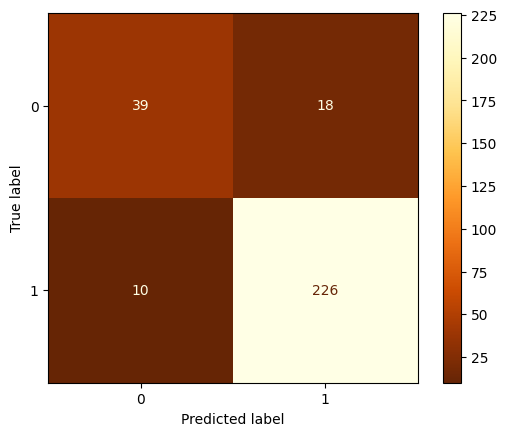

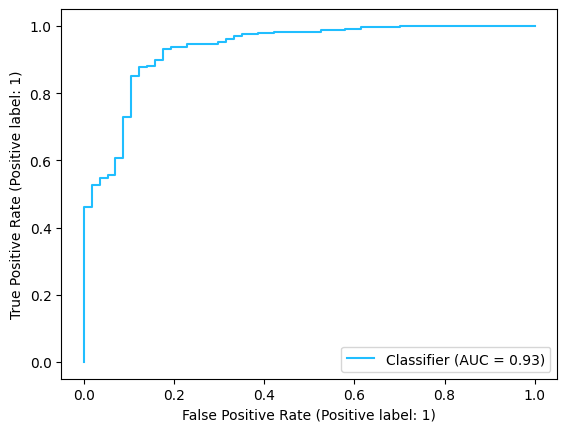

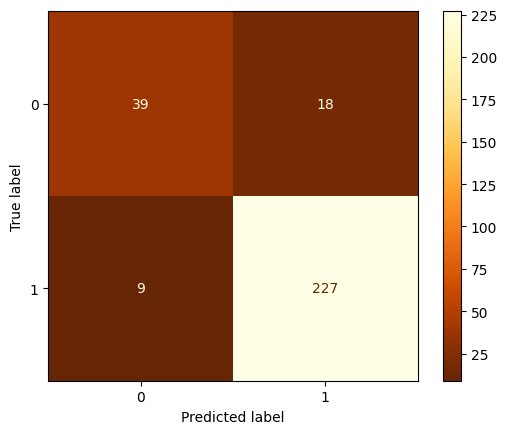

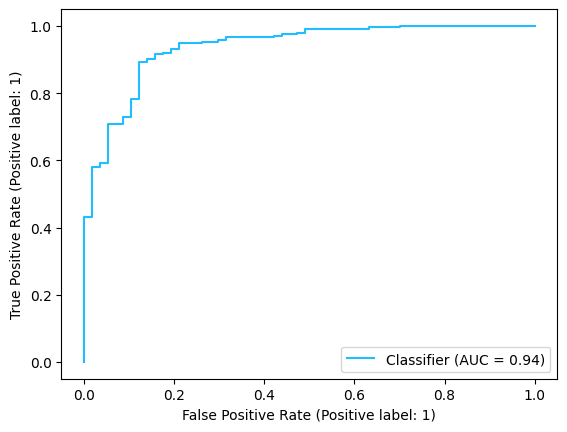

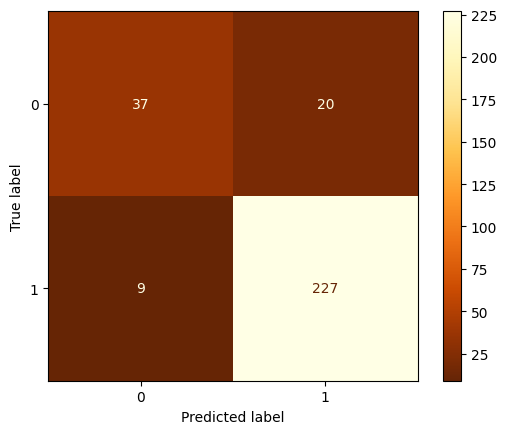

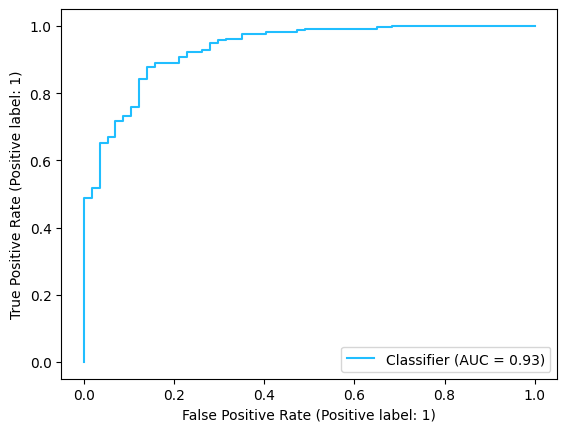

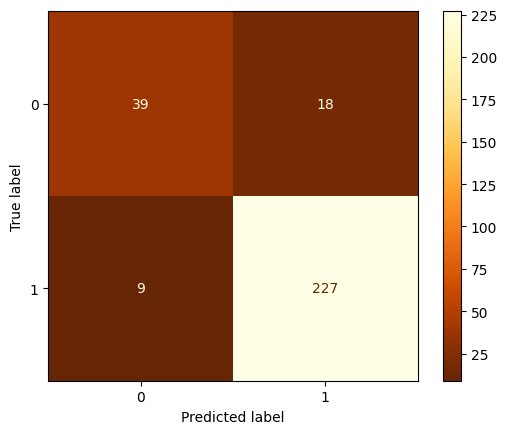

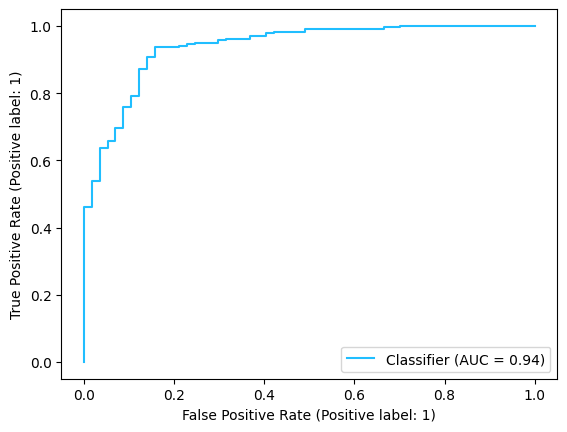

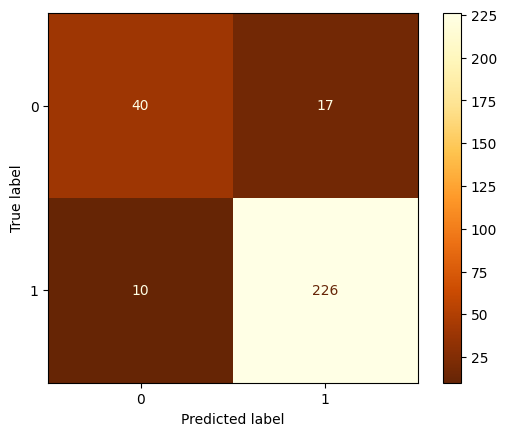

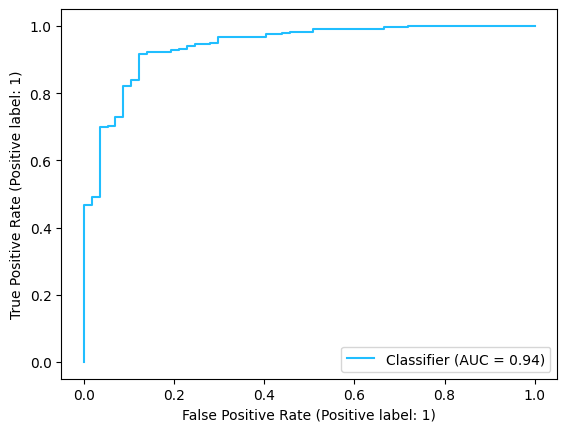

In [42]:
#x_train = train_features
x_TEST = list(TEST_features)

test_acc = []
test_pre = []
test_rec = []
test_f1 = []
test_auc = []
for i in range(5):
    y_pred = clf_models[i].predict(x_TEST)
    y_pred_prob = clf_models[i].predict_proba(x_TEST)[:,1]
    # Acc
    accuracy = accuracy_score(TEST_label, y_pred)
    test_acc.append(accuracy)
    # Precision
    precision = precision_score(TEST_label, y_pred)
    test_pre.append(precision)
    # Recall
    recall = recall_score(TEST_label, y_pred)
    test_rec.append(recall)
    # F1-score
    f1 = f1_score(TEST_label, y_pred) 
    test_f1.append(f1)
    # AUC
    auc = roc_auc_score(TEST_label, y_pred_prob) 
    test_auc.append(auc)
    print(f"No.{i}","Accuracy: %.2f%%" % (accuracy * 100), "Precision: %.2f%%" % (precision * 100), "Recall: %.2f%%" % (recall * 100), "F1: %.2f%%" % (f1 * 100), "AUC: %.2f%%" % (auc * 100))
    cm = confusion_matrix(TEST_label, y_pred)
    cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')
    RocCurveDisplay.from_predictions(TEST_label, y_pred_prob, color='#20BEFF')

print('*'*45)
print(f'Mean acc: {sum(test_acc)/5*100:.2f}%')
print(f'Mean pre: {sum(test_pre)/5*100:.2f}%')
print(f'Mean rec: {sum(test_rec)/5*100:.2f}%')
print(f'Mean F1-score: {sum(test_f1)/5*100:.2f}%')
print(f'Mean AUC: {sum(test_auc)/5*100:.2f}%')


# Non-linear SVM

In [43]:
from sklearn import svm


### 1 val_acc:0.93548 ###


### 2 val_acc:0.92979 ###


### 3 val_acc:0.91461 ###


### 4 val_acc:0.92410 ###


### 5 val_acc:0.91635 ###

=====================Kfold Performance======================

              precision    recall  f1-score   support

           0       0.83      0.77      0.80       509
           1       0.94      0.96      0.95      2125

    accuracy                           0.92      2634
   macro avg       0.89      0.86      0.87      2634
weighted avg       0.92      0.92      0.92      2634
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

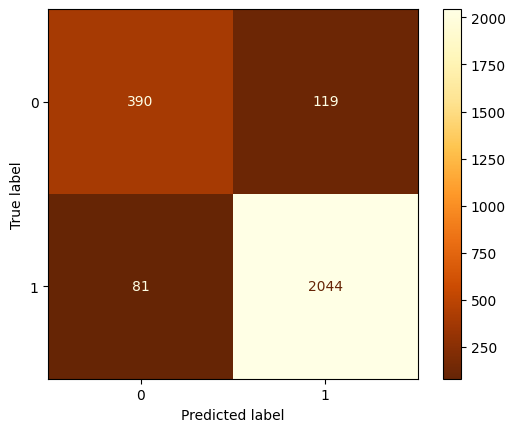

In [65]:
expected_kfold = []
predicted_kfold = []
valid_acc = []
valid_f1 = []
valid_auc = []
models = []
clf_models = []

for idx, (train_index, vali_index) in enumerate(kf.split(df)):
    x_train = [train_features[i] for i in train_index]
    y_train = train_label[train_index]
    x_vali = [train_features[i] for i in vali_index]
    y_vali = train_label[vali_index]
    
    clf = svm.NuSVC(nu=0.1, kernel='rbf', gamma='scale', probability=True) 
    clf.fit(x_train, y_train)
    
    
    # make predicitions
    expected = y_vali
    #predicted = classifier.predict(x_vali_tfidf)
    predicted = clf.predict(x_vali)
    predicted_prob = clf.predict_proba(x_vali)[:,1]
    #print(predicted_prob)
    
    expected_kfold.extend(expected)
    predicted_kfold.extend(predicted)
    models.append(classifier)
    clf_models.append(clf)
    val_score = accuracy_score(expected, predicted)
    valid_acc.append(val_score)
    val_f1 = f1_score(expected, predicted)
    valid_f1.append(val_f1)
    val_auc = roc_auc_score(expected, predicted_prob)
    valid_auc.append(val_auc)
    print(f"\n### {idx+1} val_acc:{val_score:.5f} ###\n")
    #print(f'val_acc:{val_score:.5f}')
    #print(f'{metrics.classification_report(expected, predicted)}{"-"*60:>600}')

print(f'{"===Kfold Performance===":=^60}\n')
print(f'{metrics.classification_report(expected_kfold, predicted_kfold)}{"-"*60:>600}')
print(f'5-fold ACC: {sum(valid_acc)/5*100:.2f}% std:{np.std(valid_acc)}')
print(f'5-fold F1: {sum(valid_f1)/5*100:.2f}%  std:{np.std(valid_f1)}')
print(f'5-fold AUC: {sum(valid_auc)/5*100:.2f}% std:{np.std(valid_auc)}')
print(f"\nConfusion Matrix\n")
cm = confusion_matrix(expected_kfold, predicted_kfold)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')

No.0 Accuracy: 91.81% Precision: 93.44% Recall: 96.61% F1: 95.00% AUC: 94.14%
No.1 Accuracy: 91.81% Precision: 93.09% Recall: 97.03% F1: 95.02% AUC: 95.26%
No.2 Accuracy: 90.78% Precision: 92.31% Recall: 96.61% F1: 94.41% AUC: 94.56%
No.3 Accuracy: 92.83% Precision: 93.52% Recall: 97.88% F1: 95.65% AUC: 94.88%
No.4 Accuracy: 91.47% Precision: 93.42% Recall: 96.19% F1: 94.78% AUC: 94.14%
*********************************************
Mean acc: 91.74%
Mean pre: 93.16%
Mean rec: 96.86%
Mean F1-score: 94.97%
Mean AUC: 94.60%


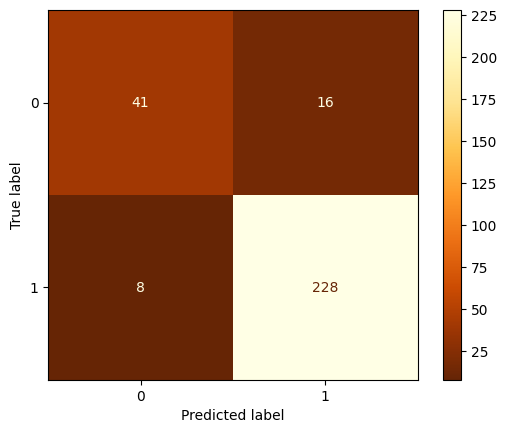

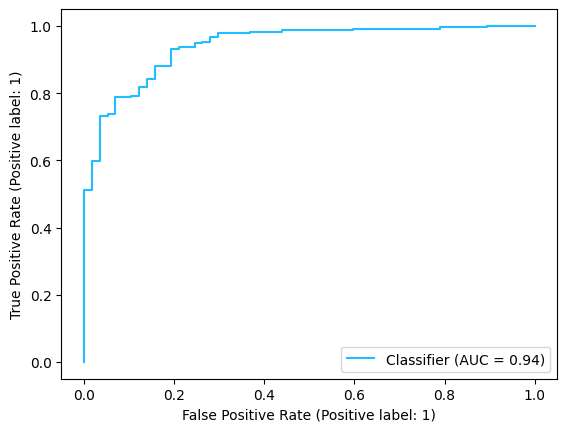

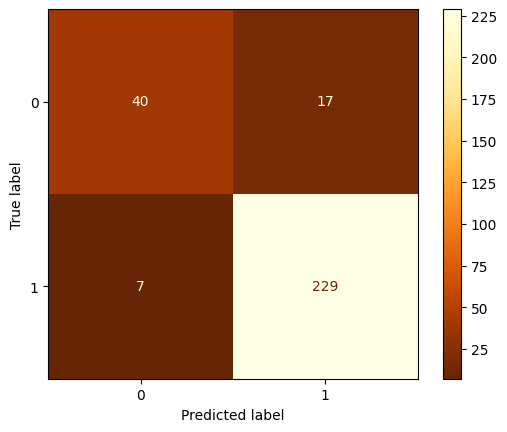

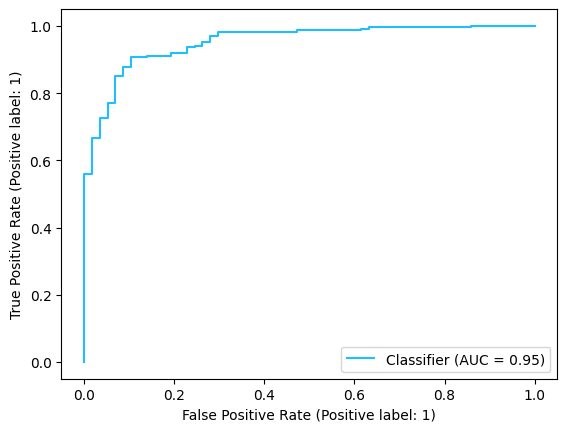

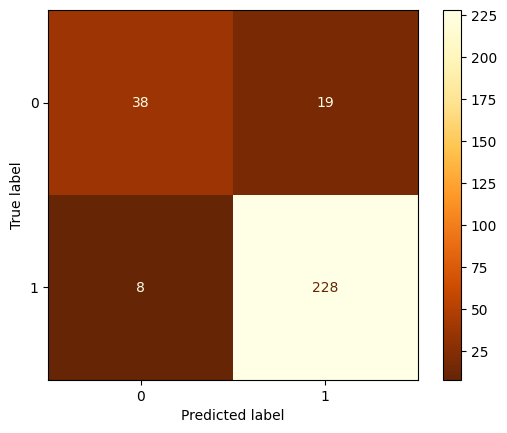

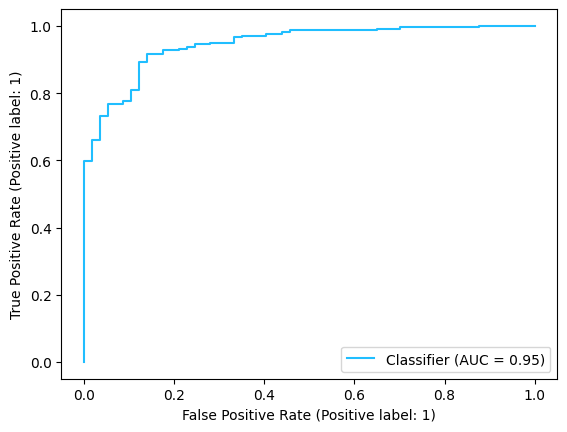

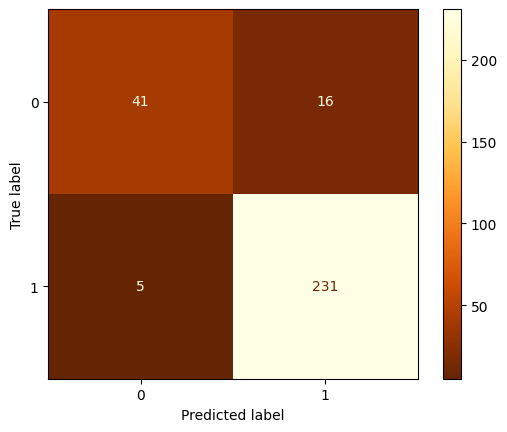

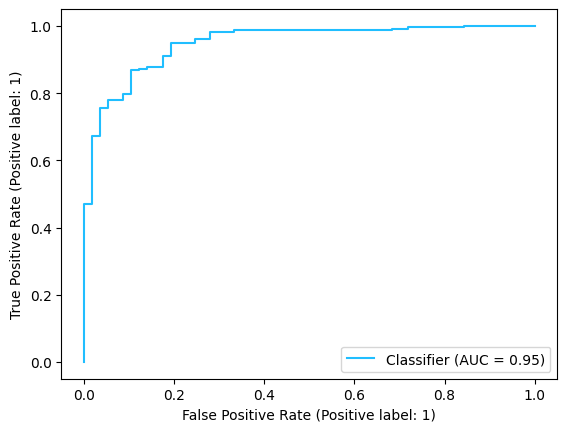

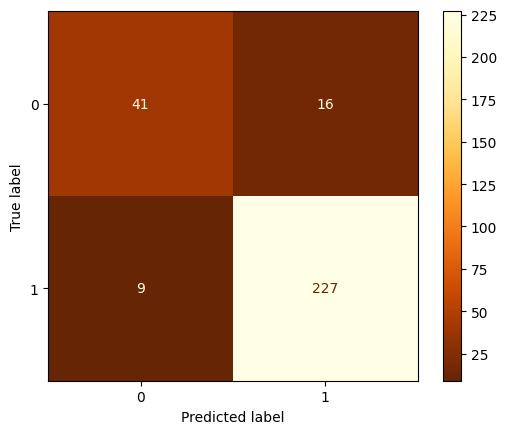

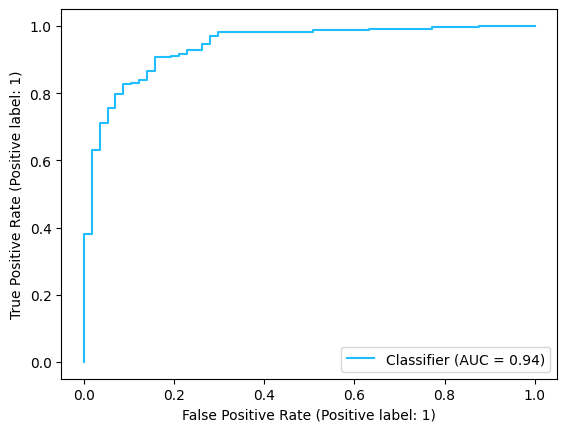

In [66]:
#x_train = train_features
x_TEST = list(TEST_features)

test_acc = []
test_pre = []
test_rec = []
test_f1 = []
test_auc = []
for i in range(5):
    y_pred = clf_models[i].predict(x_TEST)
    y_pred_prob = clf_models[i].predict_proba(x_TEST)[:,1]
    # Acc
    accuracy = accuracy_score(TEST_label, y_pred)
    test_acc.append(accuracy)
    # Precision
    precision = precision_score(TEST_label, y_pred)
    test_pre.append(precision)
    # Recall
    recall = recall_score(TEST_label, y_pred)
    test_rec.append(recall)
    # F1-score
    f1 = f1_score(TEST_label, y_pred) 
    test_f1.append(f1)
    # AUC
    auc = roc_auc_score(TEST_label, y_pred_prob) 
    test_auc.append(auc)
    print(f"No.{i}","Accuracy: %.2f%%" % (accuracy * 100), "Precision: %.2f%%" % (precision * 100), "Recall: %.2f%%" % (recall * 100), "F1: %.2f%%" % (f1 * 100), "AUC: %.2f%%" % (auc * 100))
    cm = confusion_matrix(TEST_label, y_pred)
    cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')
    RocCurveDisplay.from_predictions(TEST_label, y_pred_prob, color='#20BEFF')

print('*'*45)
print(f'Mean acc: {sum(test_acc)/5*100:.2f}%')
print(f'Mean pre: {sum(test_pre)/5*100:.2f}%')
print(f'Mean rec: {sum(test_rec)/5*100:.2f}%')
print(f'Mean F1-score: {sum(test_f1)/5*100:.2f}%')
print(f'Mean AUC: {sum(test_auc)/5*100:.2f}%')


In [67]:
# Save model for future usage
from joblib import dump, load
dump(clf_models[3], "GPT_embedding_NonLinearSVM_1127.joblib")

['GPT_embedding_NonLinearSVM_1127.joblib']

# Gemini embedding

In [2]:
from sklearn.model_selection import KFold
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
#from xgboost import XGBClassifier

from sklearn import metrics

In [3]:
df = pd.read_csv('long_covid0208_unique_train.csv')
val_df = pd.read_csv('long_covid0208_unique_valid.csv')
test_df = pd.read_csv('long_covid0208_unique_test.csv')
df = pd.concat([df, val_df])
df = df.reset_index(drop=True)
print('Split shape : ',df.shape, test_df.shape)

Split shape :  (2634, 5) (293, 5)


In [9]:
df['Gemini_Embeddings'] = df.Gemini_Embeddings.apply(eval).apply(np.array)
test_df['Gemini_Embeddings'] = test_df.Gemini_Embeddings.apply(eval).apply(np.array)

In [10]:
train_features = df["Gemini_Embeddings"].values
train_label = df["label"].values
TEST_features = test_df["Gemini_Embeddings"].values
TEST_label = test_df["label"].values

In [11]:
kf = KFold(n_splits = 5, shuffle = True)


### 1 val_acc:0.92410 ###


### 2 val_acc:0.93928 ###


### 3 val_acc:0.92789 ###


### 4 val_acc:0.91841 ###


### 5 val_acc:0.92966 ###

=====================Kfold Performance======================

              precision    recall  f1-score   support

           0       0.84      0.77      0.81       509
           1       0.95      0.97      0.96      2125

    accuracy                           0.93      2634
   macro avg       0.89      0.87      0.88      2634
weighted avg       0.93      0.93      0.93      2634
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

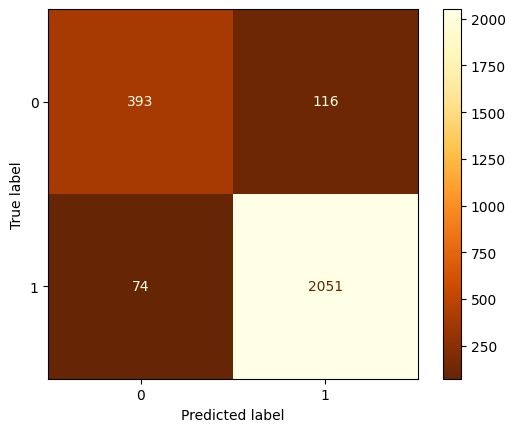

In [20]:
from sklearn import svm
expected_kfold = []
predicted_kfold = []
valid_acc = []
valid_f1 = []
valid_auc = []
models = []
clf_models = []

for idx, (train_index, vali_index) in enumerate(kf.split(df)):
    x_train = [train_features[i] for i in train_index]
    y_train = train_label[train_index]
    x_vali = [train_features[i] for i in vali_index]
    y_vali = train_label[vali_index]
    
    clf = svm.NuSVC(nu=0.1, kernel='rbf', gamma='scale', probability=True) 
    clf.fit(x_train, y_train)
    
    
    # make predicitions
    expected = y_vali
    #predicted = classifier.predict(x_vali_tfidf)
    predicted = clf.predict(x_vali)
    predicted_prob = clf.predict_proba(x_vali)[:,1]
    #print(predicted_prob)
    
    expected_kfold.extend(expected)
    predicted_kfold.extend(predicted)
    #models.append(classifier)
    clf_models.append(clf)
    val_score = accuracy_score(expected, predicted)
    valid_acc.append(val_score)
    val_f1 = f1_score(expected, predicted)
    valid_f1.append(val_f1)
    val_auc = roc_auc_score(expected, predicted_prob)
    valid_auc.append(val_auc)
    print(f"\n### {idx+1} val_acc:{val_score:.5f} ###\n")
    #print(f'val_acc:{val_score:.5f}')
    #print(f'{metrics.classification_report(expected, predicted)}{"-"*60:>600}')

print(f'{"===Kfold Performance===":=^60}\n')
print(f'{metrics.classification_report(expected_kfold, predicted_kfold)}{"-"*60:>600}')
print(f'5-fold ACC: {sum(valid_acc)/5*100:.2f}% std:{np.std(valid_acc)}')
print(f'5-fold F1: {sum(valid_f1)/5*100:.2f}%  std:{np.std(valid_f1)}')
print(f'5-fold AUC: {sum(valid_auc)/5*100:.2f}% std:{np.std(valid_auc)}')
print(f"\nConfusion Matrix\n")
cm = confusion_matrix(expected_kfold, predicted_kfold)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')


No.0 Accuracy: 90.10% Precision: 92.59% Recall: 95.34% F1: 93.95% AUC: 94.31%
No.1 Accuracy: 90.10% Precision: 92.24% Recall: 95.76% F1: 93.97% AUC: 93.58%
No.2 Accuracy: 91.13% Precision: 92.68% Recall: 96.61% F1: 94.61% AUC: 93.55%
No.3 Accuracy: 91.13% Precision: 93.03% Recall: 96.19% F1: 94.58% AUC: 92.13%
No.4 Accuracy: 91.47% Precision: 92.71% Recall: 97.03% F1: 94.82% AUC: 93.27%
*********************************************
Mean acc: 90.78%
Mean pre: 92.65%
Mean rec: 96.19%
Mean F1-score: 94.39%
Mean AUC: 93.37%


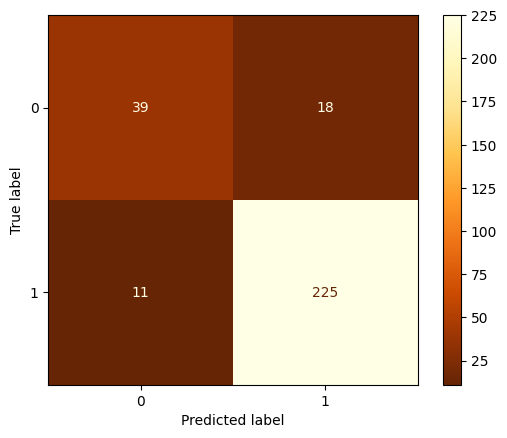

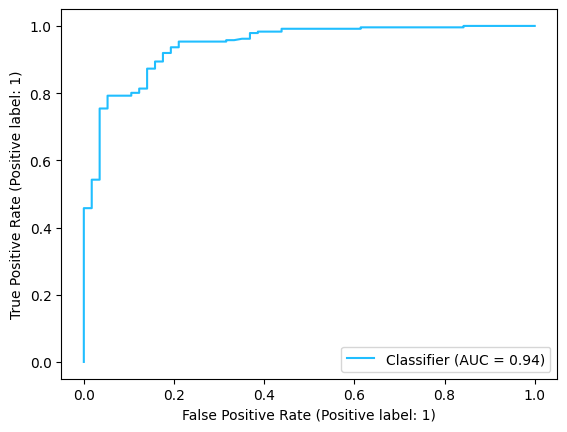

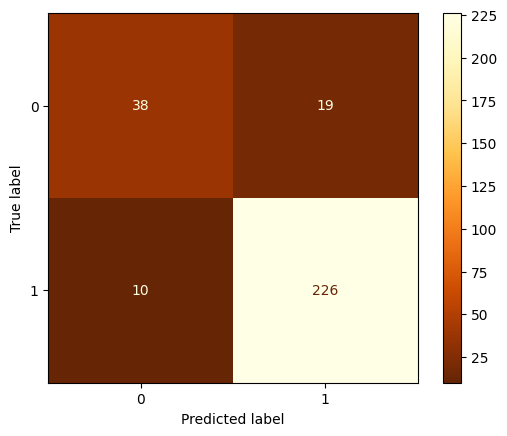

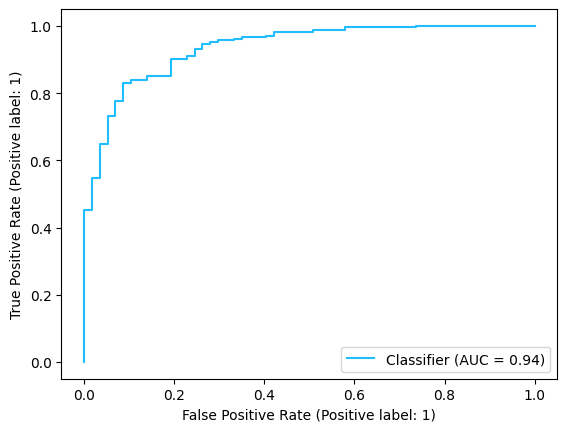

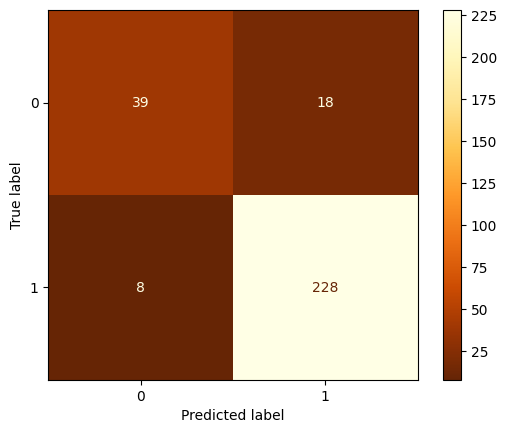

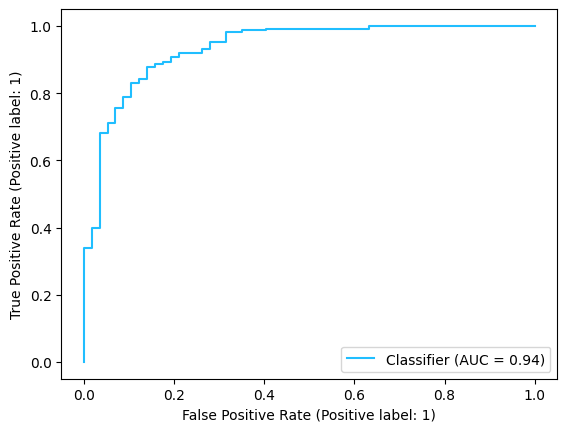

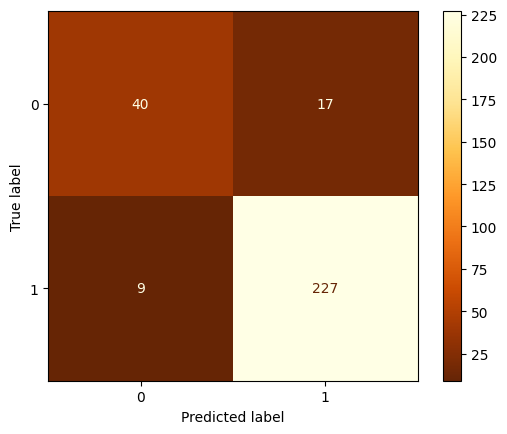

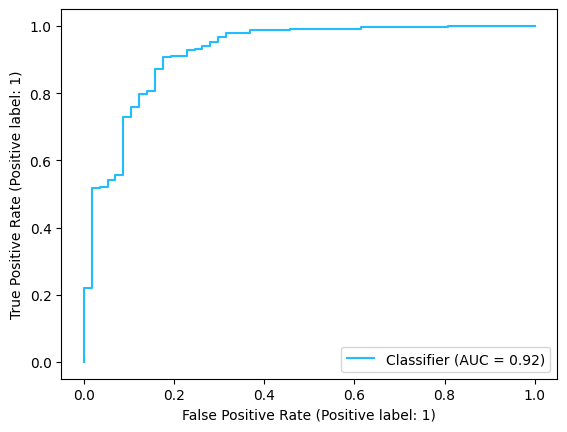

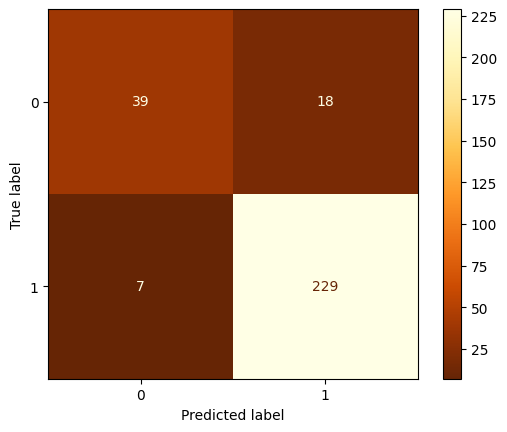

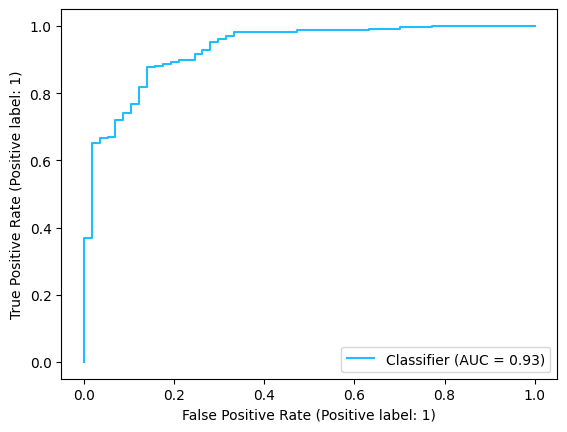

In [21]:
#x_train = train_features
x_TEST = list(TEST_features)

test_acc = []
test_pre = []
test_rec = []
test_f1 = []
test_auc = []
for i in range(5):
    y_pred = clf_models[i].predict(x_TEST)
    y_pred_prob = clf_models[i].predict_proba(x_TEST)[:,1]
    # Acc
    accuracy = accuracy_score(TEST_label, y_pred)
    test_acc.append(accuracy)
    # Precision
    precision = precision_score(TEST_label, y_pred)
    test_pre.append(precision)
    # Recall
    recall = recall_score(TEST_label, y_pred)
    test_rec.append(recall)
    # F1-score
    f1 = f1_score(TEST_label, y_pred) 
    test_f1.append(f1)
    # AUC
    auc = roc_auc_score(TEST_label, y_pred_prob) 
    test_auc.append(auc)
    print(f"No.{i}","Accuracy: %.2f%%" % (accuracy * 100), "Precision: %.2f%%" % (precision * 100), "Recall: %.2f%%" % (recall * 100), "F1: %.2f%%" % (f1 * 100), "AUC: %.2f%%" % (auc * 100))
    cm = confusion_matrix(TEST_label, y_pred)
    cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')
    RocCurveDisplay.from_predictions(TEST_label, y_pred_prob, color='#20BEFF')

print('*'*45)
print(f'Mean acc: {sum(test_acc)/5*100:.2f}%')
print(f'Mean pre: {sum(test_pre)/5*100:.2f}%')
print(f'Mean rec: {sum(test_rec)/5*100:.2f}%')
print(f'Mean F1-score: {sum(test_f1)/5*100:.2f}%')
print(f'Mean AUC: {sum(test_auc)/5*100:.2f}%')

In [24]:
# Save model for future usage
from joblib import dump, load
dump(clf_models[4], "Gemini_embeddings_NonLinearSVM_0217.joblib")

['Gemini_embeddings_NonLinearSVM_0217.joblib']

# Playground

In [12]:
from sklearn import svm
clf = svm.SVC()
clf

SVC()

# FAKES_MAML

In [2]:
!git clone https://github.com/fakenewssyria/fake_news_detection.git

Cloning into 'fake_news_detection'...
remote: Enumerating objects: 421, done.
remote: Counting objects: 100% (421/421), done.
remote: Compressing objects: 100% (314/314), done.
remote: Total 421 (delta 174), reused 334 (delta 97), pack-reused 0
Receiving objects: 100% (421/421), 7.93 MiB | 11.57 MiB/s, done.
Resolving deltas: 100% (174/174), done.


In [2]:
df = pd.read_csv('long_covid1003_unique.csv', encoding= 'unicode_escape')
print(f'Total shape : {df.shape}\nLabel distribution : \n\t0:{df.shape[0]-df.label.values.sum()}\n\t1:{df.label.values.sum()}')
df, val_df = train_test_split(df, test_size = 0.2, stratify = df.label, random_state = 42 )
val_df, test_df = train_test_split(val_df, test_size = 0.5, stratify = val_df.label, random_state = 42 )
df = pd.concat([df, val_df])
df = df.reset_index(drop=True)
print('Split shape : ',df.shape, test_df.shape)

Total shape : (2927, 3)
Label distribution : 
	0:566
	1:2361
Split shape :  (2634, 3) (293, 3)


In [4]:
wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer  = PorterStemmer()

p.set_options(p.OPT.URL, p.OPT.EMOJI)

def preprocess(row, lemmatizer, stemmer):
    text = row['tweet']
    text = text.strip('\xa0')
    text = p.clean(text)
    # tokenization = nltk.word_tokenize(text)     
    # tokenization = [w for w in tokenization if not w in stop_words]
    # text = ' '.join([porter_stemmer.stem(w) for w in tokenization])
    # text = ' '.join([lemmatizer.lemmatize(w) for w in tokenization])
    # text = re.sub(r'\([0-9]+\)', '', text).strip()    
    return text

df['tweet'] = df.apply(lambda x: preprocess(x, wordnet_lemmatizer, porter_stemmer), 1)
test_df['tweet'] = test_df.apply(lambda x: preprocess(x, wordnet_lemmatizer, porter_stemmer), 1)

In [5]:
df.to_csv('trainig0528.csv', index=False)
test_df.to_csv('test0528.csv', index=False)

In [2]:
cd fake_news_detection

/fake_news_detection


In [3]:
from feature_extraction.feature_extraction import FeatureExtraction
import os

def test_feature_extraction(input_csv, output_csv):

    # some dependencies needed for feature extraction
    import nltk
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('wordnet')
    
    # it is assumed that the stanford parsers are located in the same directory as the cloned github repository
    # if this is not the case, change the path_to_stanford_parsers variable below to the absolute path of the stanford parsers
    # e.g. /Users/username/pythonworkspace/fake-news-detection
    path_to_stanford_parsers = os.getcwd()
    
    feature_extraction = FeatureExtraction(path_to_stanford_parsers)
    feature_extraction.read_clustering_output(input_csv)
    feature_extraction.read_lexicons(assertive_lexicon_path="input/lexicons/assertive.txt",
                                         factive_lexicon_path="input/lexicons/factive.txt",
                                         implicative_lexicon_path="input/lexicons/implicative.txt",
                                         hedges_lexicon_path="input/lexicons/hedges.txt",
                                         sectarian_lexicon_path="input/lexicons/sectarian_language_lexicon.txt",
                                         report_lexicon_path="input/lexicons/report_verbs.txt",
                                         bias_lexicon_path="input/lexicons/bias.txt",
                                         subjclues_lexicon_path="input/lexicons/subjclues.txt",
                                         negative_lexicon_path="input/lexicons/negative_words.txt",
                                         positive_lexicon_path="input/lexicons/positive_words.txt")    

    feature_extraction.calculate_features()
    feature_extraction.export_features_csv(output_csv)
    
test_feature_extraction("trainig0528.csv", "feature_training_0530.csv")
test_feature_extraction("test0528.csv", "feature_test_0530.csv")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


calculating lexicon features
calculating description of quoted sources feature
report_verbs_lexicon: ['accuse', 'acknowledge', 'add', 'admit', 'advise', 'agree', 'alert', 'allege', 'announce', 'answer', 'apologize', 'argue', 'ask', 'assert', 'assure', 'beg', 'blame', 'boast', 'caution', 'charge', 'cite', 'claim', 'clarify', 'command', 'comment', 'compare', 'complain', 'concede', 'conclude', 'confirm', 'confront', 'congratulate', 'contend', 'contradict', 'convey', 'counter', 'criticize', 'debate', 'decide', 'declare', 'defend', 'demand', 'demonstrate', 'deny', 'describe', 'determine', 'disagree', 'disclose', 'discount', 'discover', 'discuss', 'dismiss', 'dispute', 'disregard', 'doubt', 'emphasize', 'encourage', 'endorse', 'equate', 'estimate', 'expect', 'explain', 'express', 'extoll', 'fear', 'feel', 'find', 'forbid', 'forecast', 'foretell', 'forget', 'gather', 'guarantee', 'guess', 'hear', 'hint', 'hope', 'illustrate', 'imagine', 'imply', 'indicate', 'inform', 'insert', 'insist', 'inst

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


calculating lexicon features
calculating description of quoted sources feature
report_verbs_lexicon: ['accuse', 'acknowledge', 'add', 'admit', 'advise', 'agree', 'alert', 'allege', 'announce', 'answer', 'apologize', 'argue', 'ask', 'assert', 'assure', 'beg', 'blame', 'boast', 'caution', 'charge', 'cite', 'claim', 'clarify', 'command', 'comment', 'compare', 'complain', 'concede', 'conclude', 'confirm', 'confront', 'congratulate', 'contend', 'contradict', 'convey', 'counter', 'criticize', 'debate', 'decide', 'declare', 'defend', 'demand', 'demonstrate', 'deny', 'describe', 'determine', 'disagree', 'disclose', 'discount', 'discover', 'discuss', 'dismiss', 'dispute', 'disregard', 'doubt', 'emphasize', 'encourage', 'endorse', 'equate', 'estimate', 'expect', 'explain', 'express', 'extoll', 'fear', 'feel', 'find', 'forbid', 'forecast', 'foretell', 'forget', 'gather', 'guarantee', 'guess', 'hear', 'hint', 'hope', 'illustrate', 'imagine', 'imply', 'indicate', 'inform', 'insert', 'insist', 'inst

In [19]:
from nltk.parse.stanford import StanfordDependencyParser

# 初始化 StanfordDependencyParser
path_to_jar = 'stanford-corenlp-full-2018-02-27/stanford-corenlp-3.9.1.jar'
path_to_models_jar = 'stanford-corenlp-full-2018-02-27/stanford-corenlp-3.9.1-models.jar'
dependency_parser = StanfordDependencyParser(path_to_jar=path_to_jar, path_to_models_jar=path_to_models_jar)

# 需要解析的句子
sentence = "No, Fauci do not admit that COVID-19 vaccines aren't working: On Nov"

try:
    # 解析句子
    dependencies = dependency_parser.raw_parse(sentence)
    # 获取解析结果
    dependencies = next(dependencies)
    # 打印依赖树的dot格式
    print(dependencies.to_dot())
except Exception as e:
    print(f"An error occurred in parsing the sentence: {e}")


An error occurred in parsing the sentence: 

NLTK was unable to find the java file!
Use software specific configuration parameters or set the JAVAHOME environment variable.


/tmp/ipykernel_139026/1162044104.py:6: DeprecationWarning: The StanfordDependencyParser will be deprecated
Please use nltk.parse.corenlp.CoreNLPDependencyParser instead.
  dependency_parser = StanfordDependencyParser(path_to_jar=path_to_jar, path_to_models_jar=path_to_models_jar)


In [4]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, auc, roc_auc_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import preprocessor as p

from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
#from xgboost import XGBClassifier

from sklearn import metrics

import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [9]:
df = pd.read_csv('feature_training.csv', encoding= 'unicode_escape')
test_df = pd.read_csv('feature_test.csv', encoding= 'unicode_escape')

train_features = df[['quoted_sources', 'assertive_verbs', 'factive_verbs', 'implicative_verbs', 'hedges', 'report_verbs', 'bias', 'sectarian_language']].values
train_label = df['label'].values
TEST_features = test_df[['quoted_sources', 'assertive_verbs', 'factive_verbs', 'implicative_verbs', 'hedges', 'report_verbs', 'bias', 'sectarian_language']].values
TEST_label = test_df["label"].values


### 1 val_acc:0.84061 ###


### 2 val_acc:0.77609 ###


### 3 val_acc:0.82163 ###


### 4 val_acc:0.79886 ###


### 5 val_acc:0.79658 ###

=====================Kfold Performance======================

              precision    recall  f1-score   support

           0       0.50      0.00      0.00       509
           1       0.81      1.00      0.89      2125

    accuracy                           0.81      2634
   macro avg       0.65      0.50      0.45      2634
weighted avg       0.75      0.81      0.72      2634
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

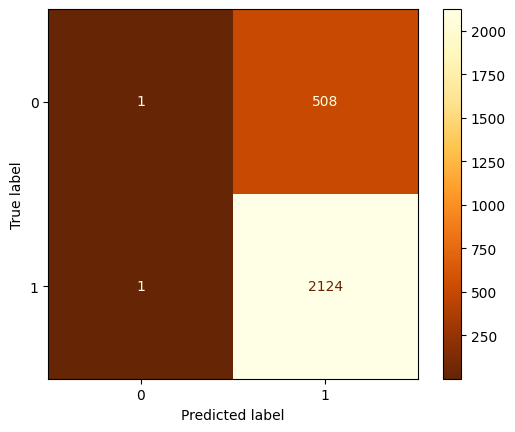

In [14]:
kf = KFold(n_splits = 5, shuffle = True)

expected_kfold = []
predicted_kfold = []
valid_acc = []
valid_f1 = []
valid_auc = []
models = []
clf_models = []

for idx, (train_index, vali_index) in enumerate(kf.split(df)):
    x_train = [train_features[i] for i in train_index]
    y_train = train_label[train_index]
    x_vali = [train_features[i] for i in vali_index]
    y_vali = train_label[vali_index]

    classifier = LinearSVC()
    #classifier.fit(x_train_tfidf, y_train)
    
    #for predict_prob
    clf = CalibratedClassifierCV(classifier) 
    clf.fit(x_train, y_train)
    
    
    # make predicitions
    expected = y_vali
    #predicted = classifier.predict(x_vali_tfidf)
    predicted = clf.predict(x_vali)
    predicted_prob = clf.predict_proba(x_vali)[:,1]
    #print(predicted_prob)
    
    expected_kfold.extend(expected)
    predicted_kfold.extend(predicted)
    models.append(classifier)
    clf_models.append(clf)
    val_score = accuracy_score(expected, predicted)
    valid_acc.append(val_score)
    val_f1 = f1_score(expected, predicted)
    valid_f1.append(val_f1)
    val_auc = roc_auc_score(expected, predicted_prob)
    valid_auc.append(val_auc)
    print(f"\n### {idx+1} val_acc:{val_score:.5f} ###\n")
    #print(f'val_acc:{val_score:.5f}')
    #print(f'{metrics.classification_report(expected, predicted)}{"-"*60:>600}')

print(f'{"===Kfold Performance===":=^60}\n')
print(f'{metrics.classification_report(expected_kfold, predicted_kfold)}{"-"*60:>600}')
print(f'5-fold ACC: {sum(valid_acc)/5*100:.2f}% std:{np.std(valid_acc)}')
print(f'5-fold F1: {sum(valid_f1)/5*100:.2f}%  std:{np.std(valid_f1)}')
print(f'5-fold AUC: {sum(valid_auc)/5*100:.2f}% std:{np.std(valid_auc)}')
print(f"\nConfusion Matrix\n")
cm = confusion_matrix(expected_kfold, predicted_kfold)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')

No.0 Accuracy: 80.55% Precision: 80.55% Recall: 100.00% F1: 89.22% AUC: 59.47%
No.1 Accuracy: 80.55% Precision: 80.55% Recall: 100.00% F1: 89.22% AUC: 59.49%
No.2 Accuracy: 80.55% Precision: 80.55% Recall: 100.00% F1: 89.22% AUC: 59.71%
No.3 Accuracy: 80.55% Precision: 80.55% Recall: 100.00% F1: 89.22% AUC: 59.05%
No.4 Accuracy: 80.55% Precision: 80.55% Recall: 100.00% F1: 89.22% AUC: 58.52%
*********************************************
Mean acc: 80.55%
Mean pre: 80.55%
Mean rec: 100.00%
Mean F1-score: 89.22%
Mean AUC: 59.25%


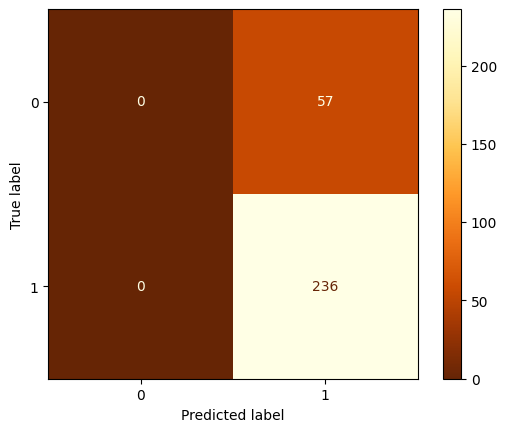

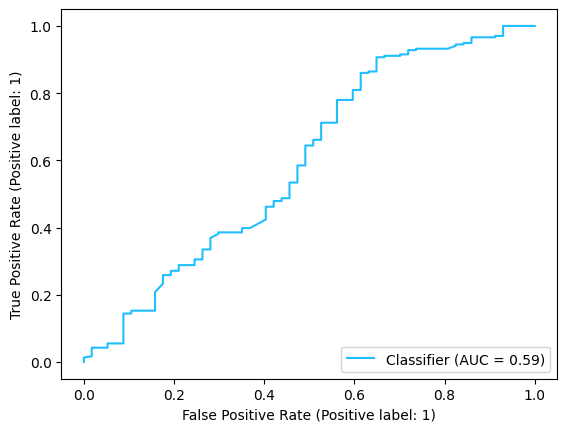

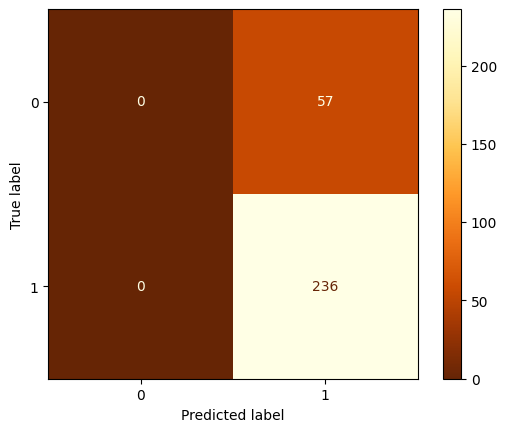

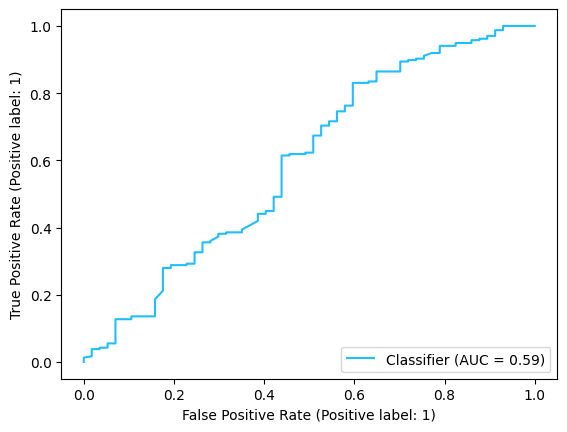

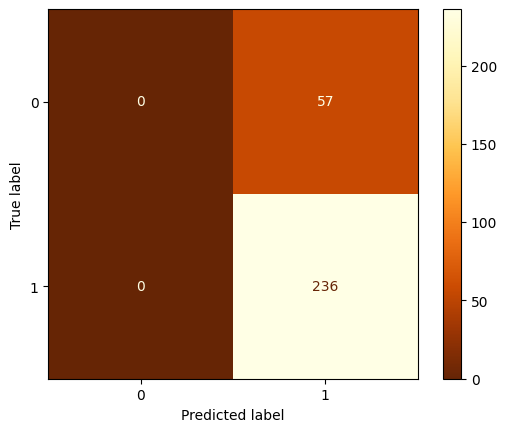

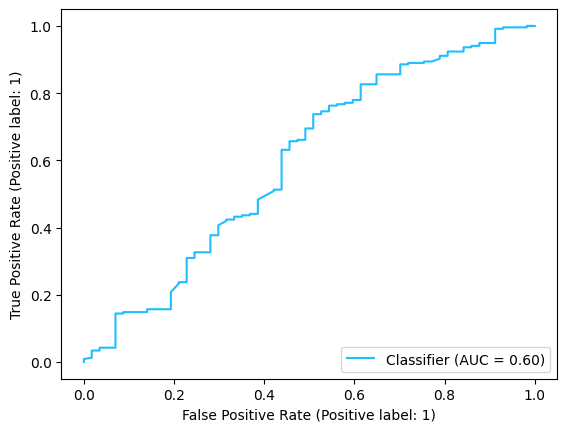

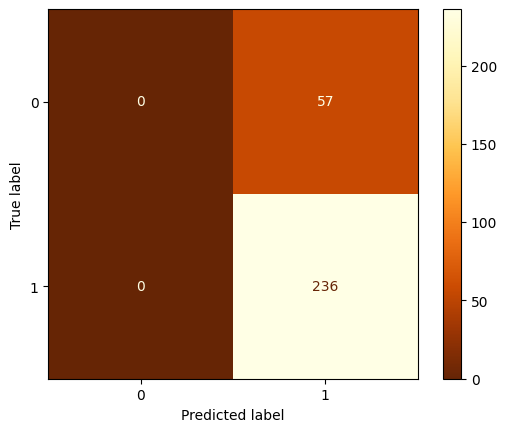

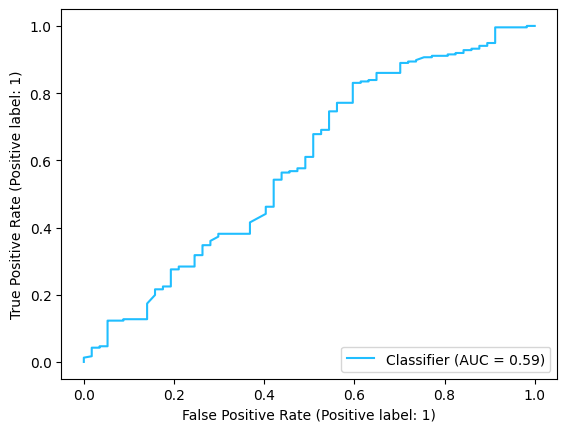

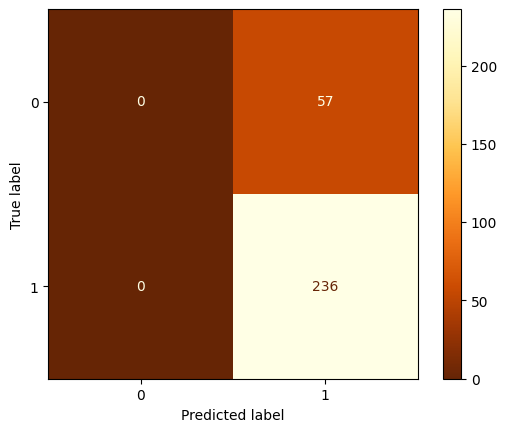

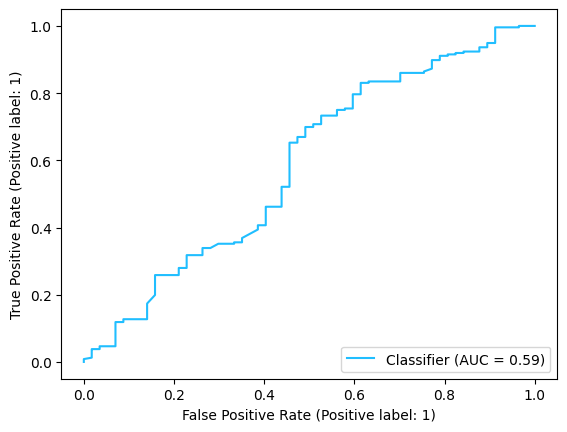

In [15]:
#x_train = train_features
x_TEST = TEST_features

test_acc = []
test_pre = []
test_rec = []
test_f1 = []
test_auc = []
for i in range(5):
    y_pred = clf_models[i].predict(x_TEST)
    y_pred_prob = clf_models[i].predict_proba(x_TEST)[:,1]
    # Acc
    accuracy = accuracy_score(TEST_label, y_pred)
    test_acc.append(accuracy)
    # Precision
    precision = precision_score(TEST_label, y_pred)
    test_pre.append(precision)
    # Recall
    recall = recall_score(TEST_label, y_pred)
    test_rec.append(recall)
    # F1-score
    f1 = f1_score(TEST_label, y_pred) 
    test_f1.append(f1)
    # AUC
    auc = roc_auc_score(TEST_label, y_pred_prob) 
    test_auc.append(auc)
    print(f"No.{i}","Accuracy: %.2f%%" % (accuracy * 100), "Precision: %.2f%%" % (precision * 100), "Recall: %.2f%%" % (recall * 100), "F1: %.2f%%" % (f1 * 100), "AUC: %.2f%%" % (auc * 100))
    cm = confusion_matrix(TEST_label, y_pred)
    cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r')
    RocCurveDisplay.from_predictions(TEST_label, y_pred_prob, color='#20BEFF')

print('*'*45)
print(f'Mean acc: {sum(test_acc)/5*100:.2f}%')
print(f'Mean pre: {sum(test_pre)/5*100:.2f}%')
print(f'Mean rec: {sum(test_rec)/5*100:.2f}%')
print(f'Mean F1-score: {sum(test_f1)/5*100:.2f}%')
print(f'Mean AUC: {sum(test_auc)/5*100:.2f}%')
